In [1]:
import torch 
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
from Sensation1 import Sensation
from Sensation1.config import config
import pickle

In [2]:
@torch.no_grad()
def calculate_ReadOutLength():
    device = 'cuda'
    dtype = torch.float16
    max_length = 30000
    
    video = cv2.VideoCapture('CalcReadOutLength.mp4')
    if not video.isOpened():
        raise Exception('can not open video!')
    frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    resizer = transforms.Resize(config.frame_size)
    
    sense = Sensation(device,False)
    sense.LoadEncoder()
    sense.LoadDeltaTime()
    Encoder = sense.encoder
    Encoder.eval()
    DeltaTime = sense.deltaT
    DeltaTime.eval()
    ReadOutMem = torch.zeros((max_length,sense.MemorySize),dtype=dtype,device=device)
    
    current_length = 1
    saver = []
    
    for idx in range(frames):
        ret,img = video.read()
        data = torch.from_numpy(img).permute(2,1,0).unsqueeze(0).to(device)
        data = (resizer(data/255)).type(dtype)
        encs = Encoder(data).view(-1)
        data = encs.unsqueeze(0).repeat(current_length,1)
        distances = DeltaTime(data,ReadOutMem[:current_length]).view(-1)
        mins = torch.min(distances)
        if mins > 0.0:
            ReadOutMem[current_length] = encs
            current_length += 1
            print('\r{:5.2f}% {}'.format(current_length/max_length*100,current_length),end='')
        saver.append(current_length)
        if not(current_length < max_length):
            print('\nmeasure finished')
            print(f'{idx} frames')
            break
        if idx % 1000 == 0:
            torch.cuda.empty_cache()
    return saver
result = calculate_ReadOutLength()
with open('ReadOutMemory_result.pkl','wb') as f:
    pickle.dump(result,f)
with open('ReadOutMemory_result.txt','w') as f:
    f.write(','.join([str(i) for i in result]))

sensation1 : loaded Encoder
sensation1 : loaded DeltaT
57.85% 17356

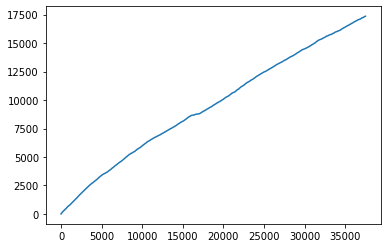

In [5]:
%matplotlib inline
plt.plot(result[:])
plt.show()